> ### Data Collection and Exploration

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
gdp = \
    pd.read_csv('Datasets/GDP.csv',index_col=0,parse_dates=True)

In [4]:
gdp.rename({'NA000334Q':'GDP'},axis=1,inplace=True)

In [5]:
gdp

GDP
DATE                 
1975-01-01   391688.0
1975-04-01   414253.0
1975-07-01   423323.0
1975-10-01   455641.0
1976-01-01   441178.0
...               ...
2022-01-01  6098908.0
2022-04-01  6414266.0
2022-07-01  6539219.0
2022-10-01  6701519.0
2023-01-01  6546655.0

[193 rows x 1 columns]

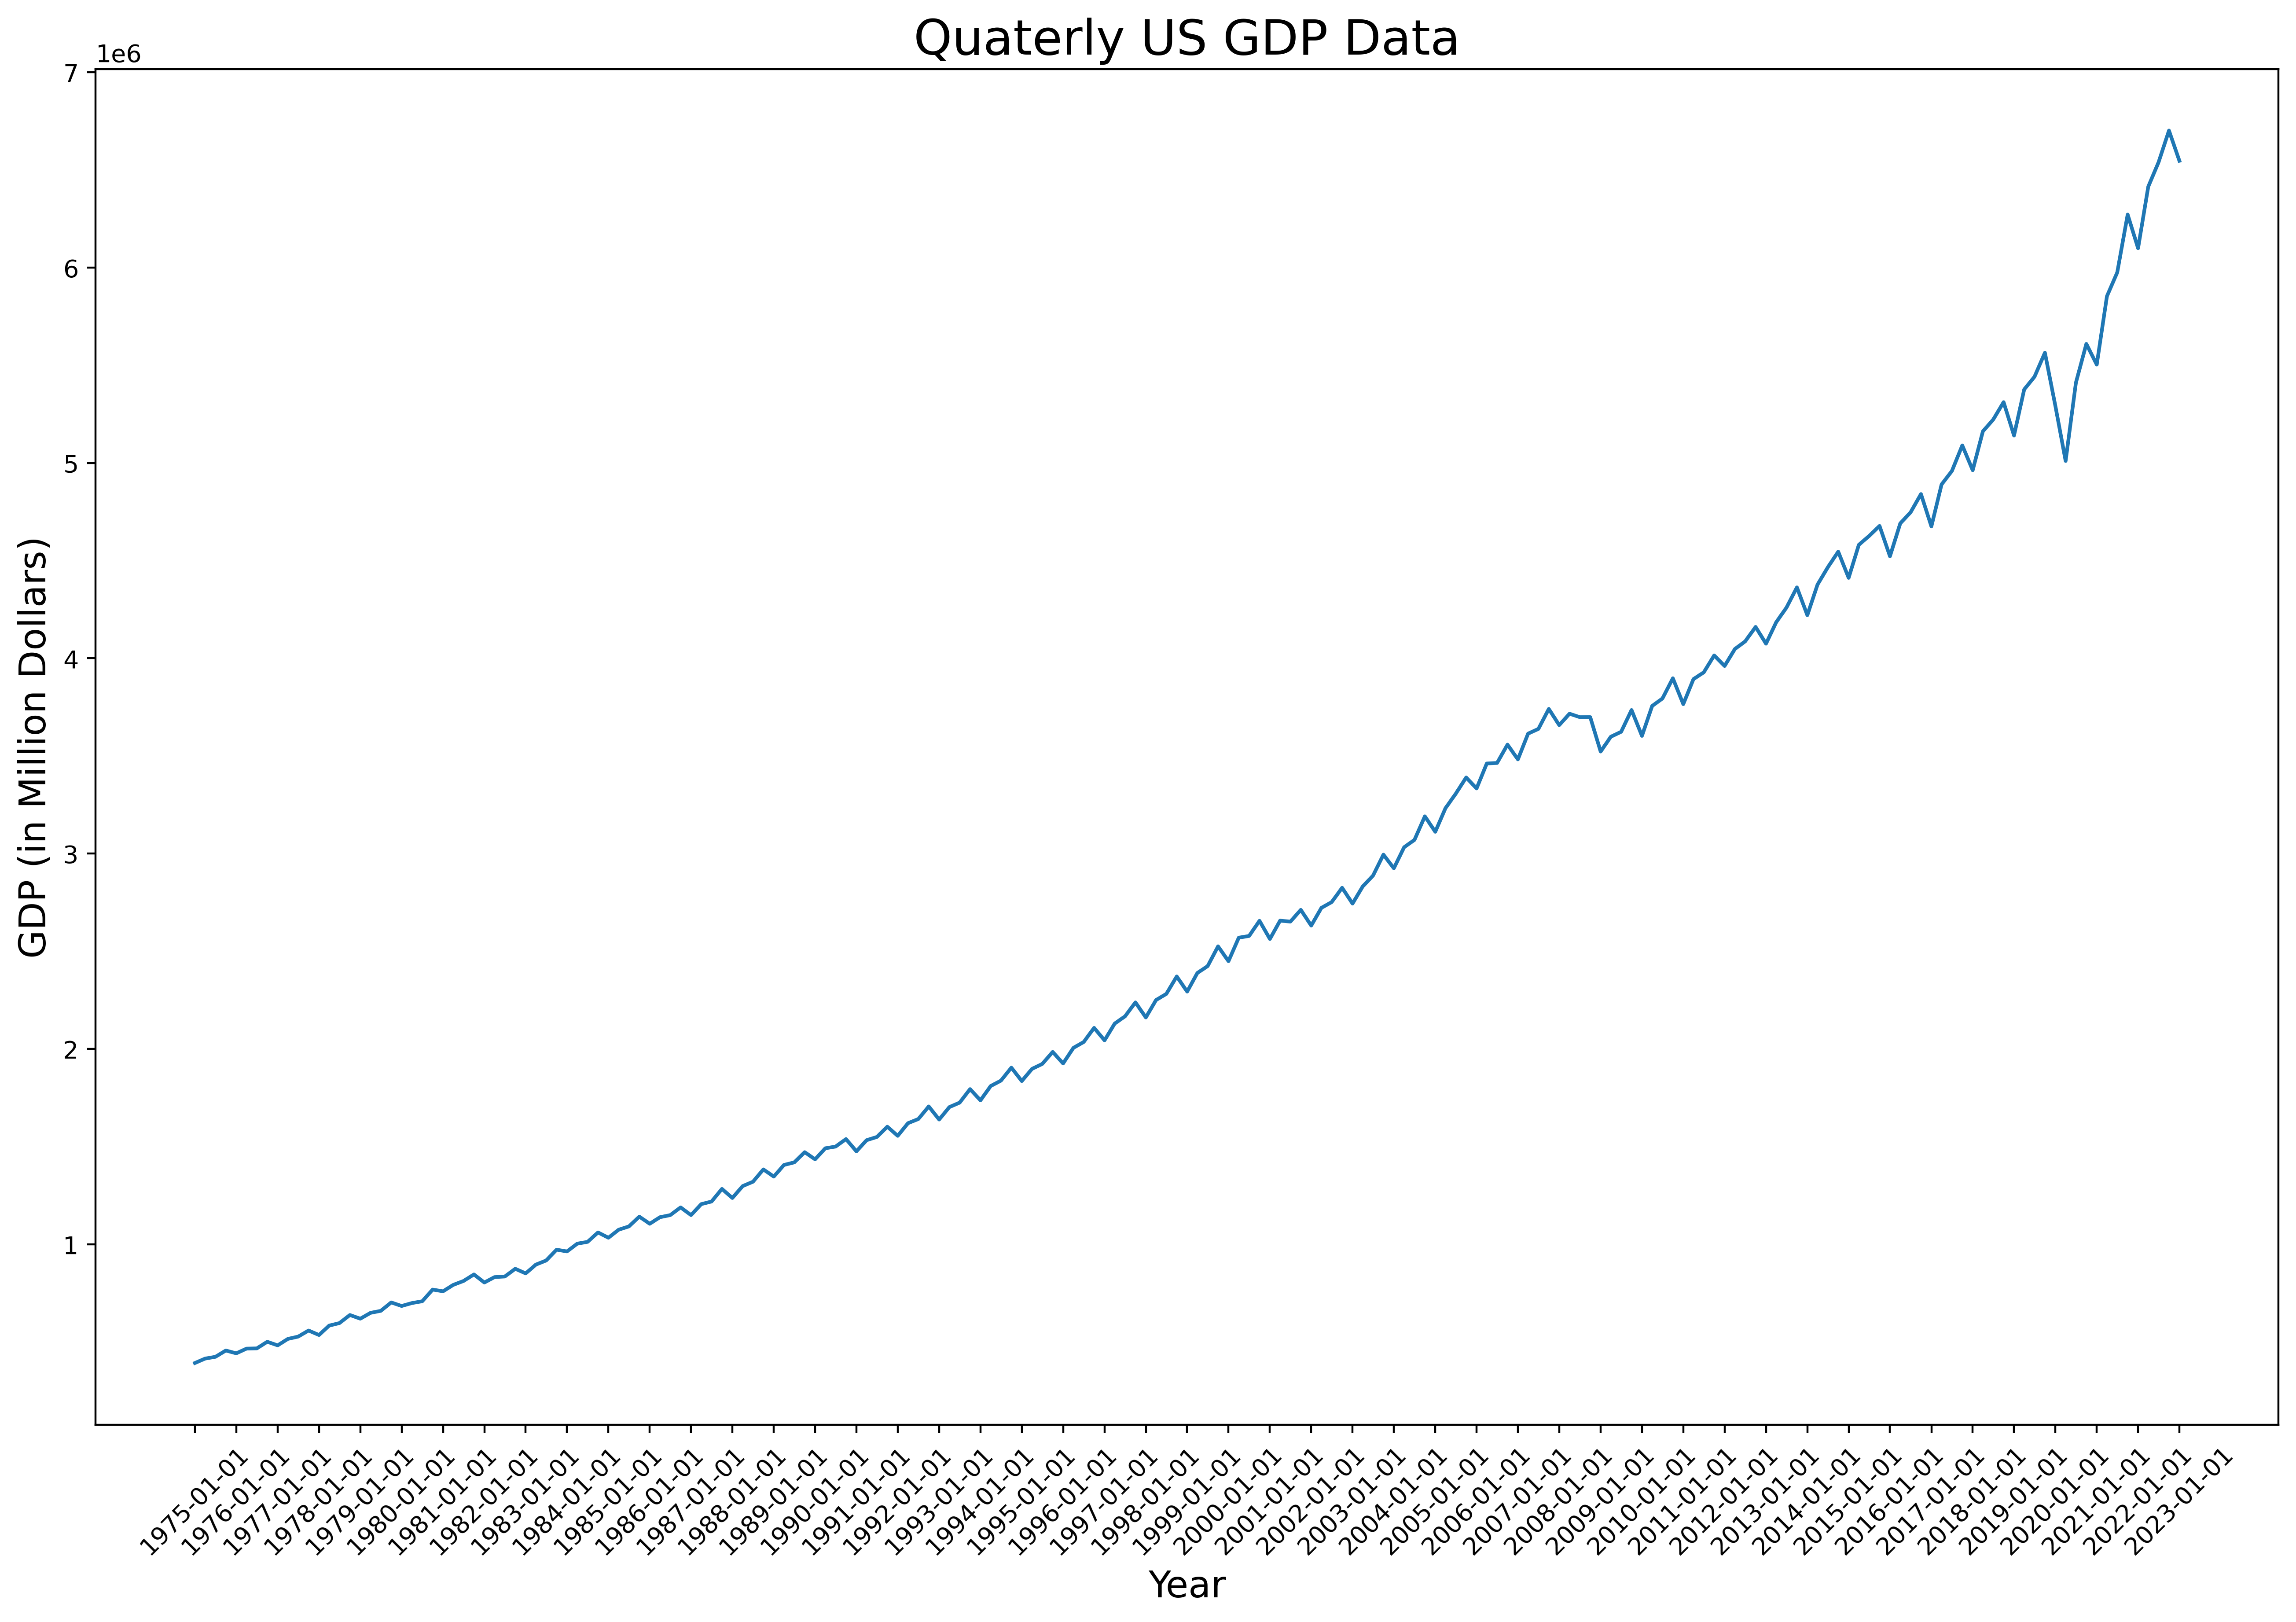

In [6]:
plt.figure(figsize=[16,10],
          dpi=400)
plt.plot(gdp)
plt.title('Quaterly US GDP Data',fontsize=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('GDP (in Million Dollars)',fontsize=15)
plt.xticks(gdp.index[::4],rotation=45)
plt.show()

> ### Time Series Decomposition

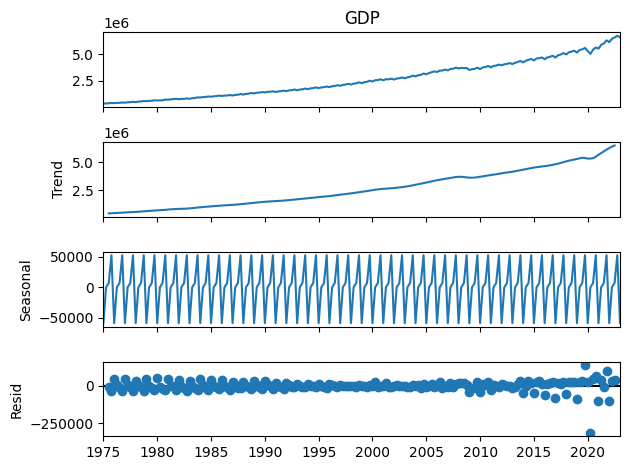

In [7]:
from statsmodels.tsa.seasonal import seasonal_decompose

result = seasonal_decompose(gdp['GDP'], model='additive',period=4)
result.plot()
plt.show()

> ### Stationarity

> #### ACF and PACF

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

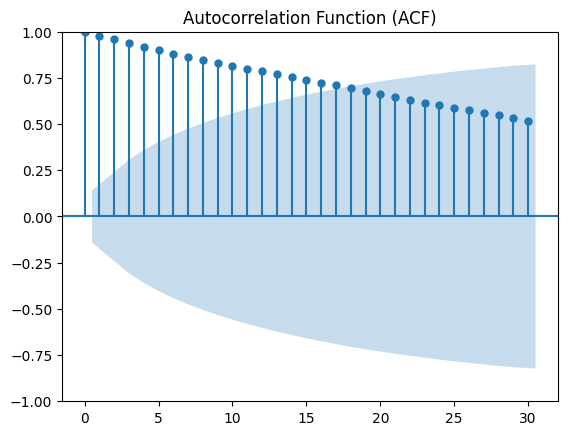

In [9]:
# Plot ACF
plot_acf(gdp['GDP'], lags=30)  
plt.title('Autocorrelation Function (ACF)')
plt.show()

> Slowly decaying ACF suggests that their is a significant trend component present in the data and hence it not stationary.

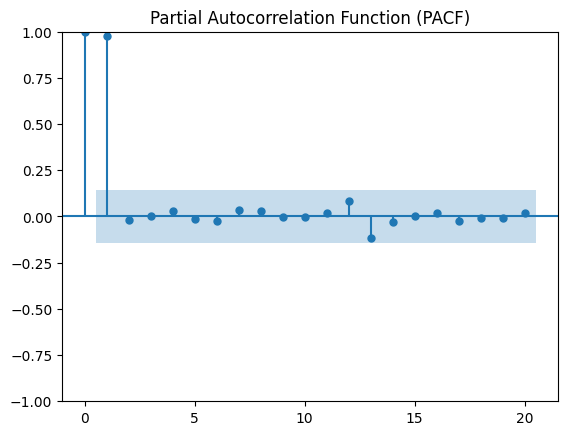

In [10]:
# Plot PACF
plot_pacf(gdp['GDP'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

> #### Augmented Dicky Fuller Test

In [11]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(gdp['GDP'])

test_statistic = result[0]
p_value = result[1]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')

Test Statistic: 3.1806739470688186
P-value: 1.0


> Null Hypothesis (H0): The time series data has a unit root, meaning it is non-stationary.

> Alternative Hypothesis (H1): The time series data does not have a unit root, meaning it is stationary.

> Test Statistic is not significant hence we cannot reject the null hypothesis of data being not stationary

> #### KPSS Test

In [12]:
from statsmodels.tsa.stattools import kpss

result = kpss(gdp['GDP'])

test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
critical_values = result[3]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags Used: {lags_used}')
print(f'Critical Values: {critical_values}')

Test Statistic: 1.9963324151083859
P-value: 0.01
Lags Used: 9
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\prasa\AppData\Local\Temp\ipykernel_9984\2943749210.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(gdp['GDP'])


> Test Statistic is significant hence we can reject the null hypothesis of data being stationary

> #### Adjusting for deterministic variation

> We are taking percentage change value rather than the absolute value of GDP because any parameters we fit will generally need to adapt to “average” range encountered in series, and result will (by definition) be a compromised

In [13]:
gdp_percent = gdp['GDP'].pct_change()
gdp_percent = gdp_percent.dropna()

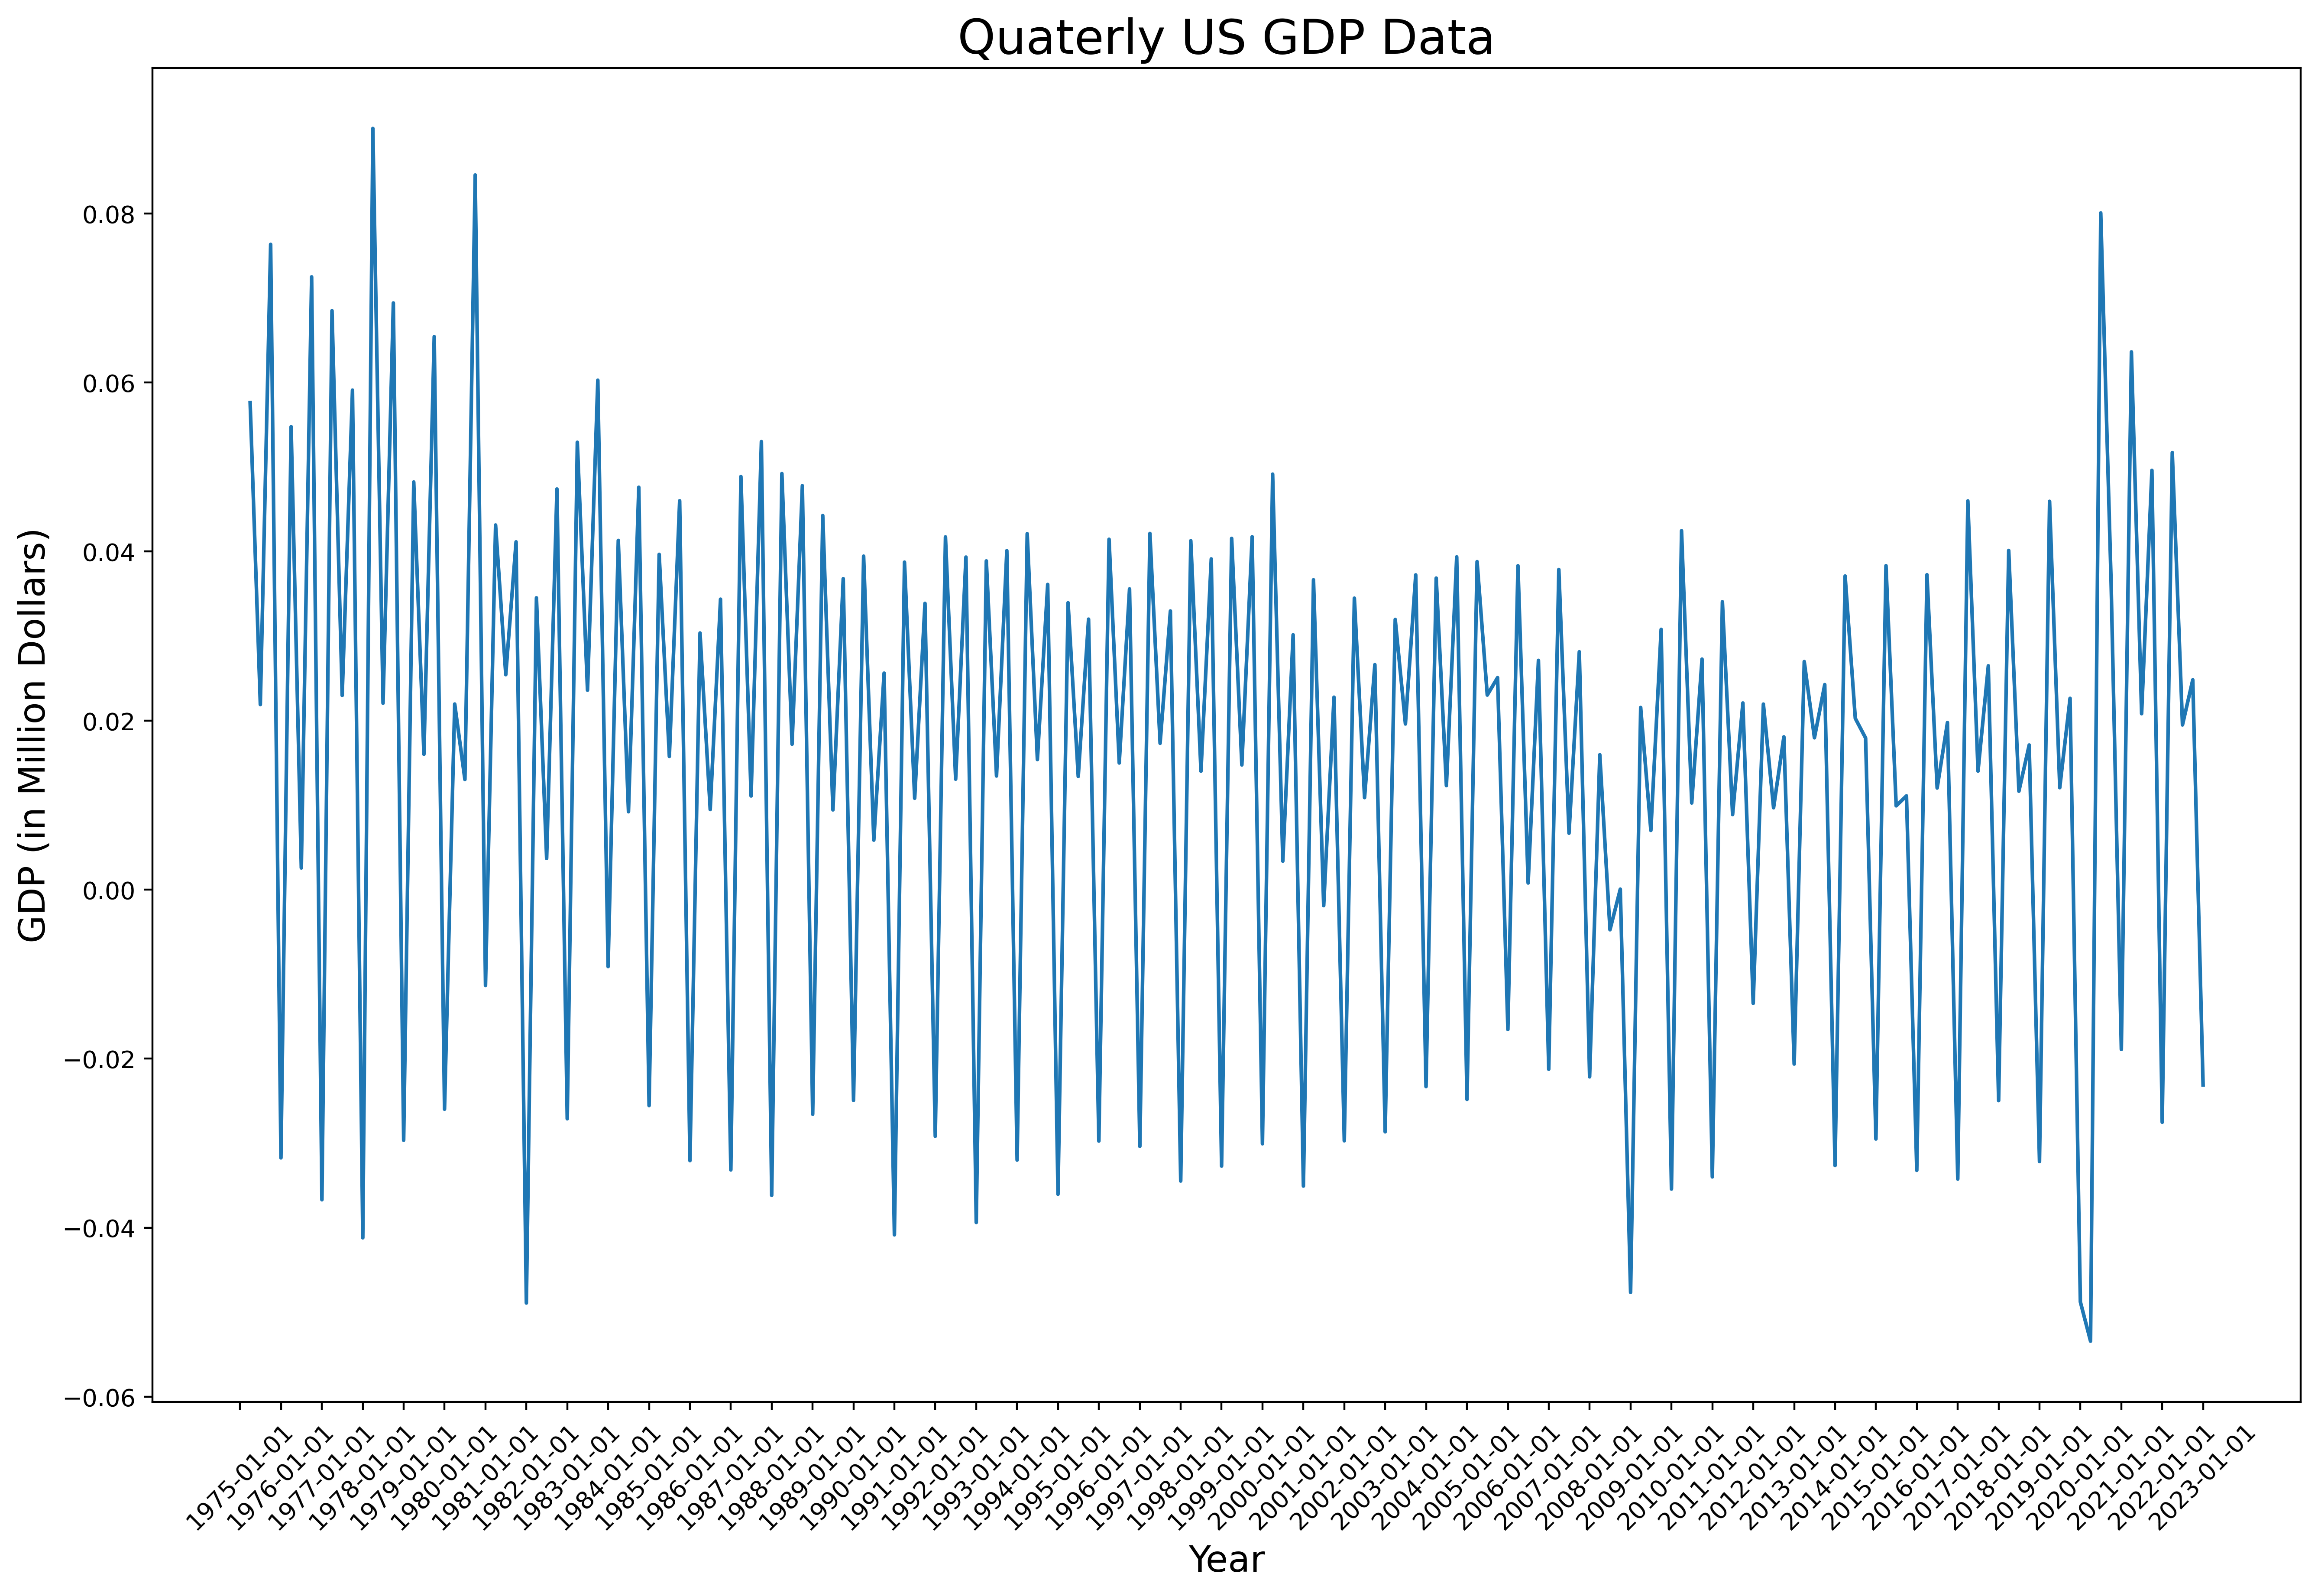

In [14]:
plt.figure(figsize=[16,10],
          dpi=400)
plt.plot(gdp_percent)
plt.title('Quaterly US GDP Data',fontsize=20)
plt.xlabel('Year',fontsize=15)
plt.ylabel('GDP (in Million Dollars)',fontsize=15)
plt.xticks(gdp.index[::4],rotation=45)
plt.show()

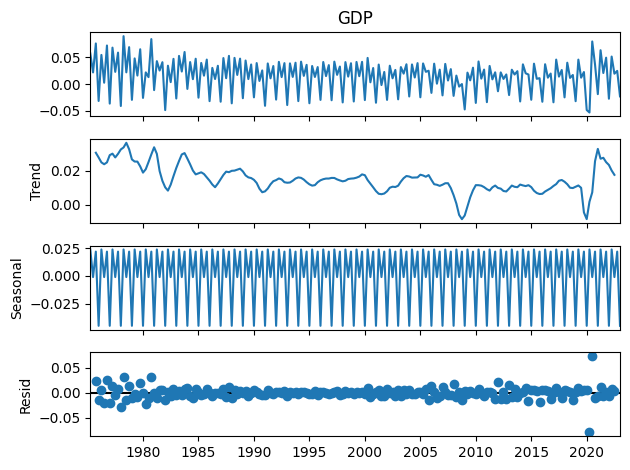

In [15]:
result = seasonal_decompose(gdp_percent, model='additive',period=4)
result.plot()
plt.show()

> Lets plot the ACF/PACF to check the stationarity of our percentage data

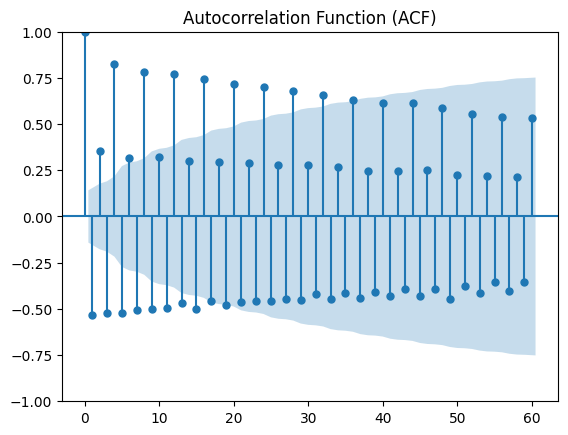

In [16]:
# Plot ACF
plot_acf(gdp_percent, lags=60)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

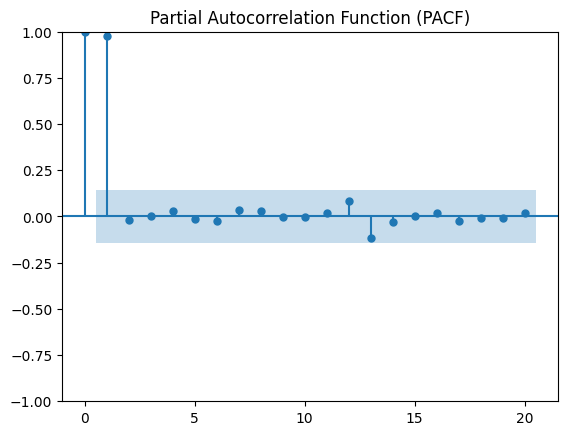

In [17]:
# Plot PACF
plot_pacf(gdp['GDP'], lags=20)  # Adjust 'lags' as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

> From ACF we can see that there is still seasonal trend in the data and hence not stationary. Lets cross check with the KPSS test.

In [18]:
#KPSS Test

result = kpss(gdp_percent)

test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
critical_values = result[3]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags Used: {lags_used}')
print(f'Critical Values: {critical_values}')

Test Statistic: 0.6579762376318412
P-value: 0.017365796578923523
Lags Used: 23
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


> Still data is not stationary so we have to take the differencing. We will take the seasonal differencing first and then first differencing if needed

> From the ACF and PACF plots we can see that we might need 1 seasonal and 1 non-seasonal differncing
but we can't tell if there is a seasonal or non seasonal AR component present

In [19]:
gdp_differenced = gdp_percent.diff(4)

In [20]:
gdp_differenced = gdp_differenced.dropna()

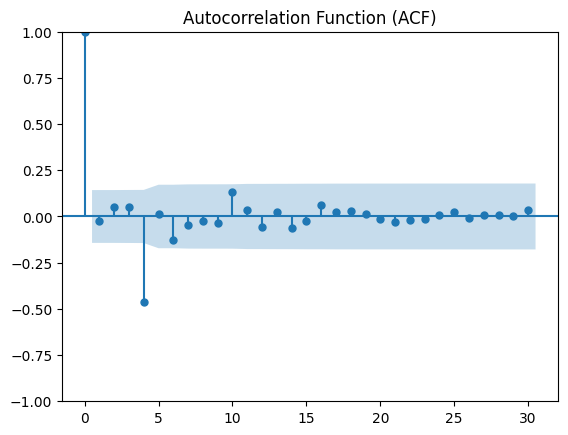

In [21]:
# Plot ACF
plot_acf(gdp_differenced, lags=30)  
plt.title('Autocorrelation Function (ACF)')
plt.show()

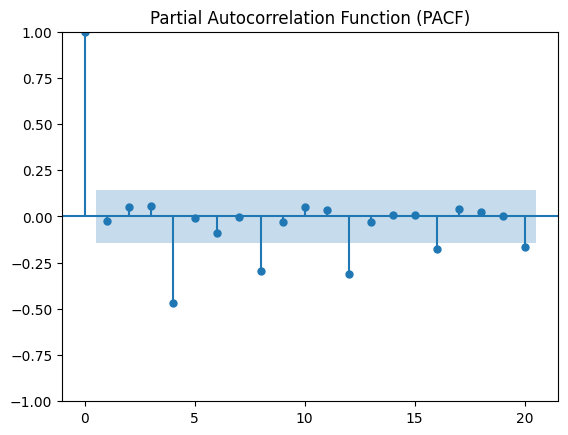

In [22]:
plot_pacf(gdp_differenced, lags=20)  # Adjust 'lags' as needed
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

> we can see that PACF is gradually decreasing at seasonal lags and in ACF cutoff after first lag. So it is suggesting presence of 1 seasonal MA component. 

In [23]:
#KPSS Test

result = kpss(gdp_differenced)

test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
critical_values = result[3]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags Used: {lags_used}')
print(f'Critical Values: {critical_values}')

Test Statistic: 0.03786910872246576
P-value: 0.1
Lags Used: 3
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\prasa\AppData\Local\Temp\ipykernel_9984\1618786293.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(gdp_differenced)


> Test Statistic is not significant and we cannot reject the null hypothesis of data being stationary 

> Lets go forward and fit the model using (1, 0, 0)(1, 1, 1) order. This is only a benchmark, we need to compare models using AICc and choose the best model.

### Fitting and Forecasting with SARIMA

In [24]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [25]:
def SARIMA(data, order, seasonal_order):
    model = SARIMAX(data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
    results = model.fit()
    aicc = results.aicc
    resid = results.resid
    return aicc, resid

In [26]:
data = gdp_percent
order = (1, 0, 0)
seasonal_order = (1, 1, 1, 4)

AICc, resid = SARIMA(data, order, seasonal_order)
print(f'AICc value of the model is:{AICc}')

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


AICc value of the model is:-1047.1121235095284


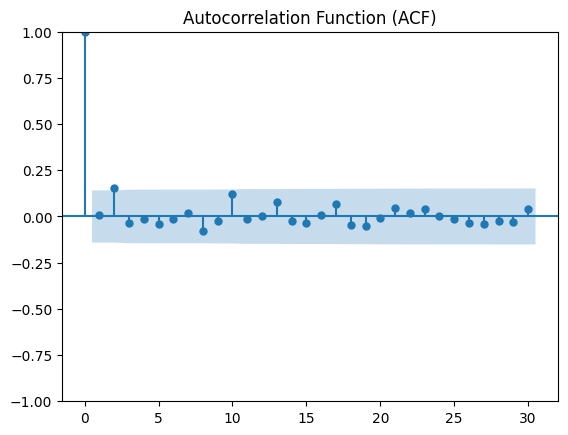

In [27]:
# Plot ACF
plot_acf(resid, lags=30)  
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [28]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [29]:
# Perform the Ljung-Box and Box-Pierce test
lags = 10

acorr_ljungbox(resid, lags=lags, return_df=True, boxpierce=True).iloc[-1]

lb_stat      10.080520
lb_pvalue     0.433458
bp_stat       9.691293
bp_pvalue     0.467982
Name: 10, dtype: float64

> From the above result we can infer that there is no correlation in the residuals and our model is able to capture all the information. But lets go ahead and use auto.arima() function to check if we get better model than our benchmark with lower AICc

In [30]:
from pmdarima import auto_arima

In [31]:
model = auto_arima(gdp_percent,seasonal=True,m=4)
order = model.get_params()['order']
seasonal_order = model.get_params()['seasonal_order']

order, seasonal_order

((1, 1, 1), (2, 0, 1, 4))

In [32]:
data = gdp_percent
order = order
seasonal_order = seasonal_order

AICc, resid = SARIMA(data, order, seasonal_order)
print(f'AICc of the model is {AICc}')

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


AICc of the model is -1036.7473918769892


C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


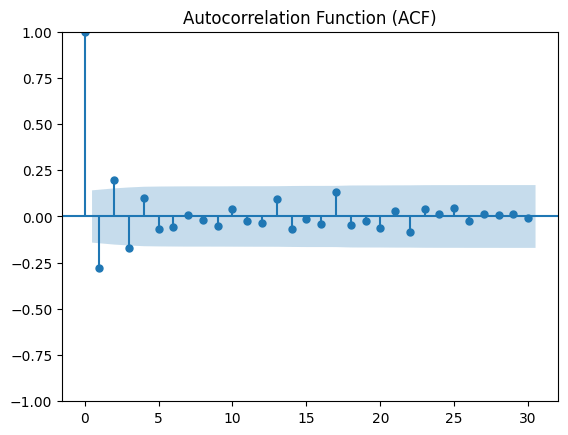

In [33]:
# Plot ACF
plot_acf(resid, lags=30)  
plt.title('Autocorrelation Function (ACF)')
plt.show()

In [34]:
# Perform the Ljung-Box and Box-Pierce test
lags = 10

acorr_ljungbox(resid, lags=lags, return_df=True, boxpierce=True).iloc[-1]

lb_stat      33.233751
lb_pvalue     0.000249
bp_stat      32.510513
bp_pvalue     0.000329
Name: 10, dtype: float64

> From both the graph and hypothesis test we can infer that there is correlation in the data and model is not working properly

### Model Evaluation

In [35]:
# Lets evaluate the predicitve power of both the model by spliting the data and comparing 
# the Error values 

In [36]:
#Split data
train_size = int(0.8*len(gdp_percent))
train, test = gdp_percent[:train_size], gdp_percent[train_size:]

> Calculate evaluation metrics such as Mean Absolute Error(MAE), Mean Squared Error(MSE), Root Mean Squared Error(RMSE)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [38]:
def evaluateModel(data, forecast, results):
    #MAE
    mae = mean_absolute_error(data, forecast)
    #MSE
    mse = mean_squared_error(data, forecast)
    rmse = np.sqrt(mse)
    
    print(f'MAE:{mae}')
    print(f'MSE:{mse}')
    print(f'RMSE:{rmse}')
    print(f'AICc:{results.aicc}')

In [39]:
# model 1
data = train
order = (1, 0, 0)
seasonal_order = (1, 1, 1, 4)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
results = model.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

evaluateModel(test, forecast_mean, results)

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


MAE:0.012560581479062706
MSE:0.00044109842365639155
RMSE:0.021002343289652028
AICc:-911.0879657328053


In [40]:
# model 2
data = train
order = (1, 1, 1)
seasonal_order = (2, 0, 1, 4)
forecast_steps = len(test)

model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
results = model.fit()
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean

evaluateModel(test, forecast_mean, results)

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


MAE:0.014485090895785051
MSE:0.0004876632450902582
RMSE:0.022083098629727176
AICc:-892.8234946129127


C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


> From residual analysis and also evaluating model with out of sample data, it seems that our benchmark model performing best.

> But we still need to check for other combinations of orders hence lets try to tune the hyperparameters using Grid Search algorithm (Hyndman-Khandakar algorithm)

In [41]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_SARIMA_model(data, train, test, order, seasonal_order):
    
    model = SARIMAX(data, 
                    order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False)
    
    results = model.fit()
    
#     forecast_steps = len(test)
#     forecast = results.get_forecast(steps=forecast_steps)
#     forecast_mean = forecast.predicted_mean
    
#     error = mean_squared_error(test,
#                                forecast_mean)
    
    aicc = results.aicc
    
    return aicc #, error

def assess_models(data, train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P,D,Q,s)
                            try:
                                aicc  = assess_SARIMA_model(data, train, test, order, seasonal_order)
                                if aicc < best_score:
                                    best_score, best_cfg = aicc, [order, seasonal_order]

#                                 print("SARIMA%s MSE = %.7f" % ([order, seasonal_order], mse))

                            except:
                                continue
    print("Best ARIMA%s AICc = %.7f" % (best_cfg, best_score))
    
# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
P_values = [0, 1, 2]
D_values = range(0, 2)
Q_values = range(0, 2)
train_size = int(0.8*len(gdp_percent))
train, test = gdp_percent[:train_size], gdp_percent[train_size:]
s = 4 # seasonal component
data = gdp_percent

In [42]:
assess_models(data, train, test, p_values, d_values, q_values, P_values, D_values, Q_values, s)

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

Best ARIMA[(0, 0, 0), (1, 0, 1, 4)] AICc = -1083.8298908


C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


> ### Residual Analysis

> Lets fit the model using order we have got from our analysis (0, 0, 0), (1, 0, 1, 4) and check the residuals

In [43]:
data = gdp_percent
order = (0, 0, 0)
seasonal_order = (1, 0, 1, 4)

final_model = SARIMAX(data, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)
results = final_model.fit()

residuals = results.resid

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [44]:
results.aicc

-1083.8298907511003

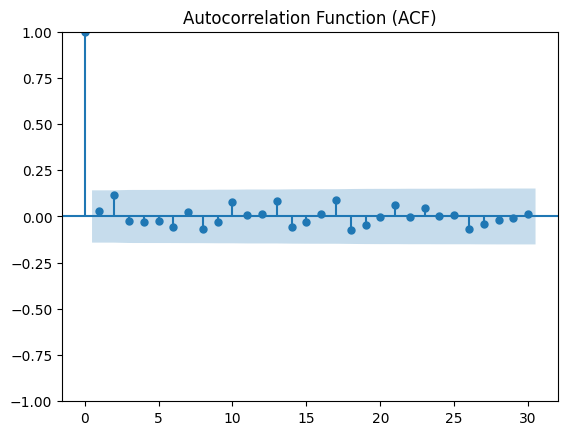

In [45]:
# Plot ACF
plot_acf(residuals, lags=30)  # Adjust 'lags' as needed
plt.title('Autocorrelation Function (ACF)')
plt.show()

> From ACF we can visually see that there is no correlation left in the residuals. Lets test this using Ljung-Box Test

> ### Ljung Box and Box-Pierce Test

In [46]:
from statsmodels.stats.diagnostic import acorr_ljungbox

In [47]:
# Perform the Ljung-Box and Box-Pierce test
lags = 10

acorr_ljungbox(residuals, lags=lags, return_df=True, boxpierce=True).iloc[-1]

lb_stat      6.487440
lb_pvalue    0.772785
bp_stat      6.245520
bp_pvalue    0.794231
Name: 10, dtype: float64

> From both the test we can see that p-value is significant and hence we cannot reject the null hypothesis that there is no autocorrelation left in the residuals

> Lets visualize our in-sample and out-of-sample forecasted data

In [48]:
train_size = int(0.8*len(gdp_percent))
train, test = gdp_percent[:train_size], gdp_percent[train_size:]

order = (0, 0, 0)
seasonal_order = (1, 0, 1, 4)
forecast_steps = len(test)

final_model = \
    SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False)

results = \
    final_model.fit()

final_forecast = results.get_forecast(steps=forecast_steps)

final_forecast_mean = final_forecast.predicted_mean

final_forecast_ci = final_forecast.conf_int()

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [49]:
results.aicc

-950.175556960297

In [50]:
final_mse = mean_absolute_error(test, final_forecast_mean)
final_rmse = np.sqrt(mean_squared_error(test, final_forecast_mean))

final_mse, final_rmse

(0.014983146363484759, 0.022411438309382203)

In [51]:
# Predict out of sample values

model = SARIMAX(gdp_percent, 
                order=(0, 0, 0), 
                seasonal_order=(1, 0, 1, 4), 
                enforce_stationarity=False)

results = model.fit()

forecast_future = results.get_forecast(steps = 8)

forecast_future_mean = forecast_future.predicted_mean

forecast_future_ci = forecast_future.conf_int()

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


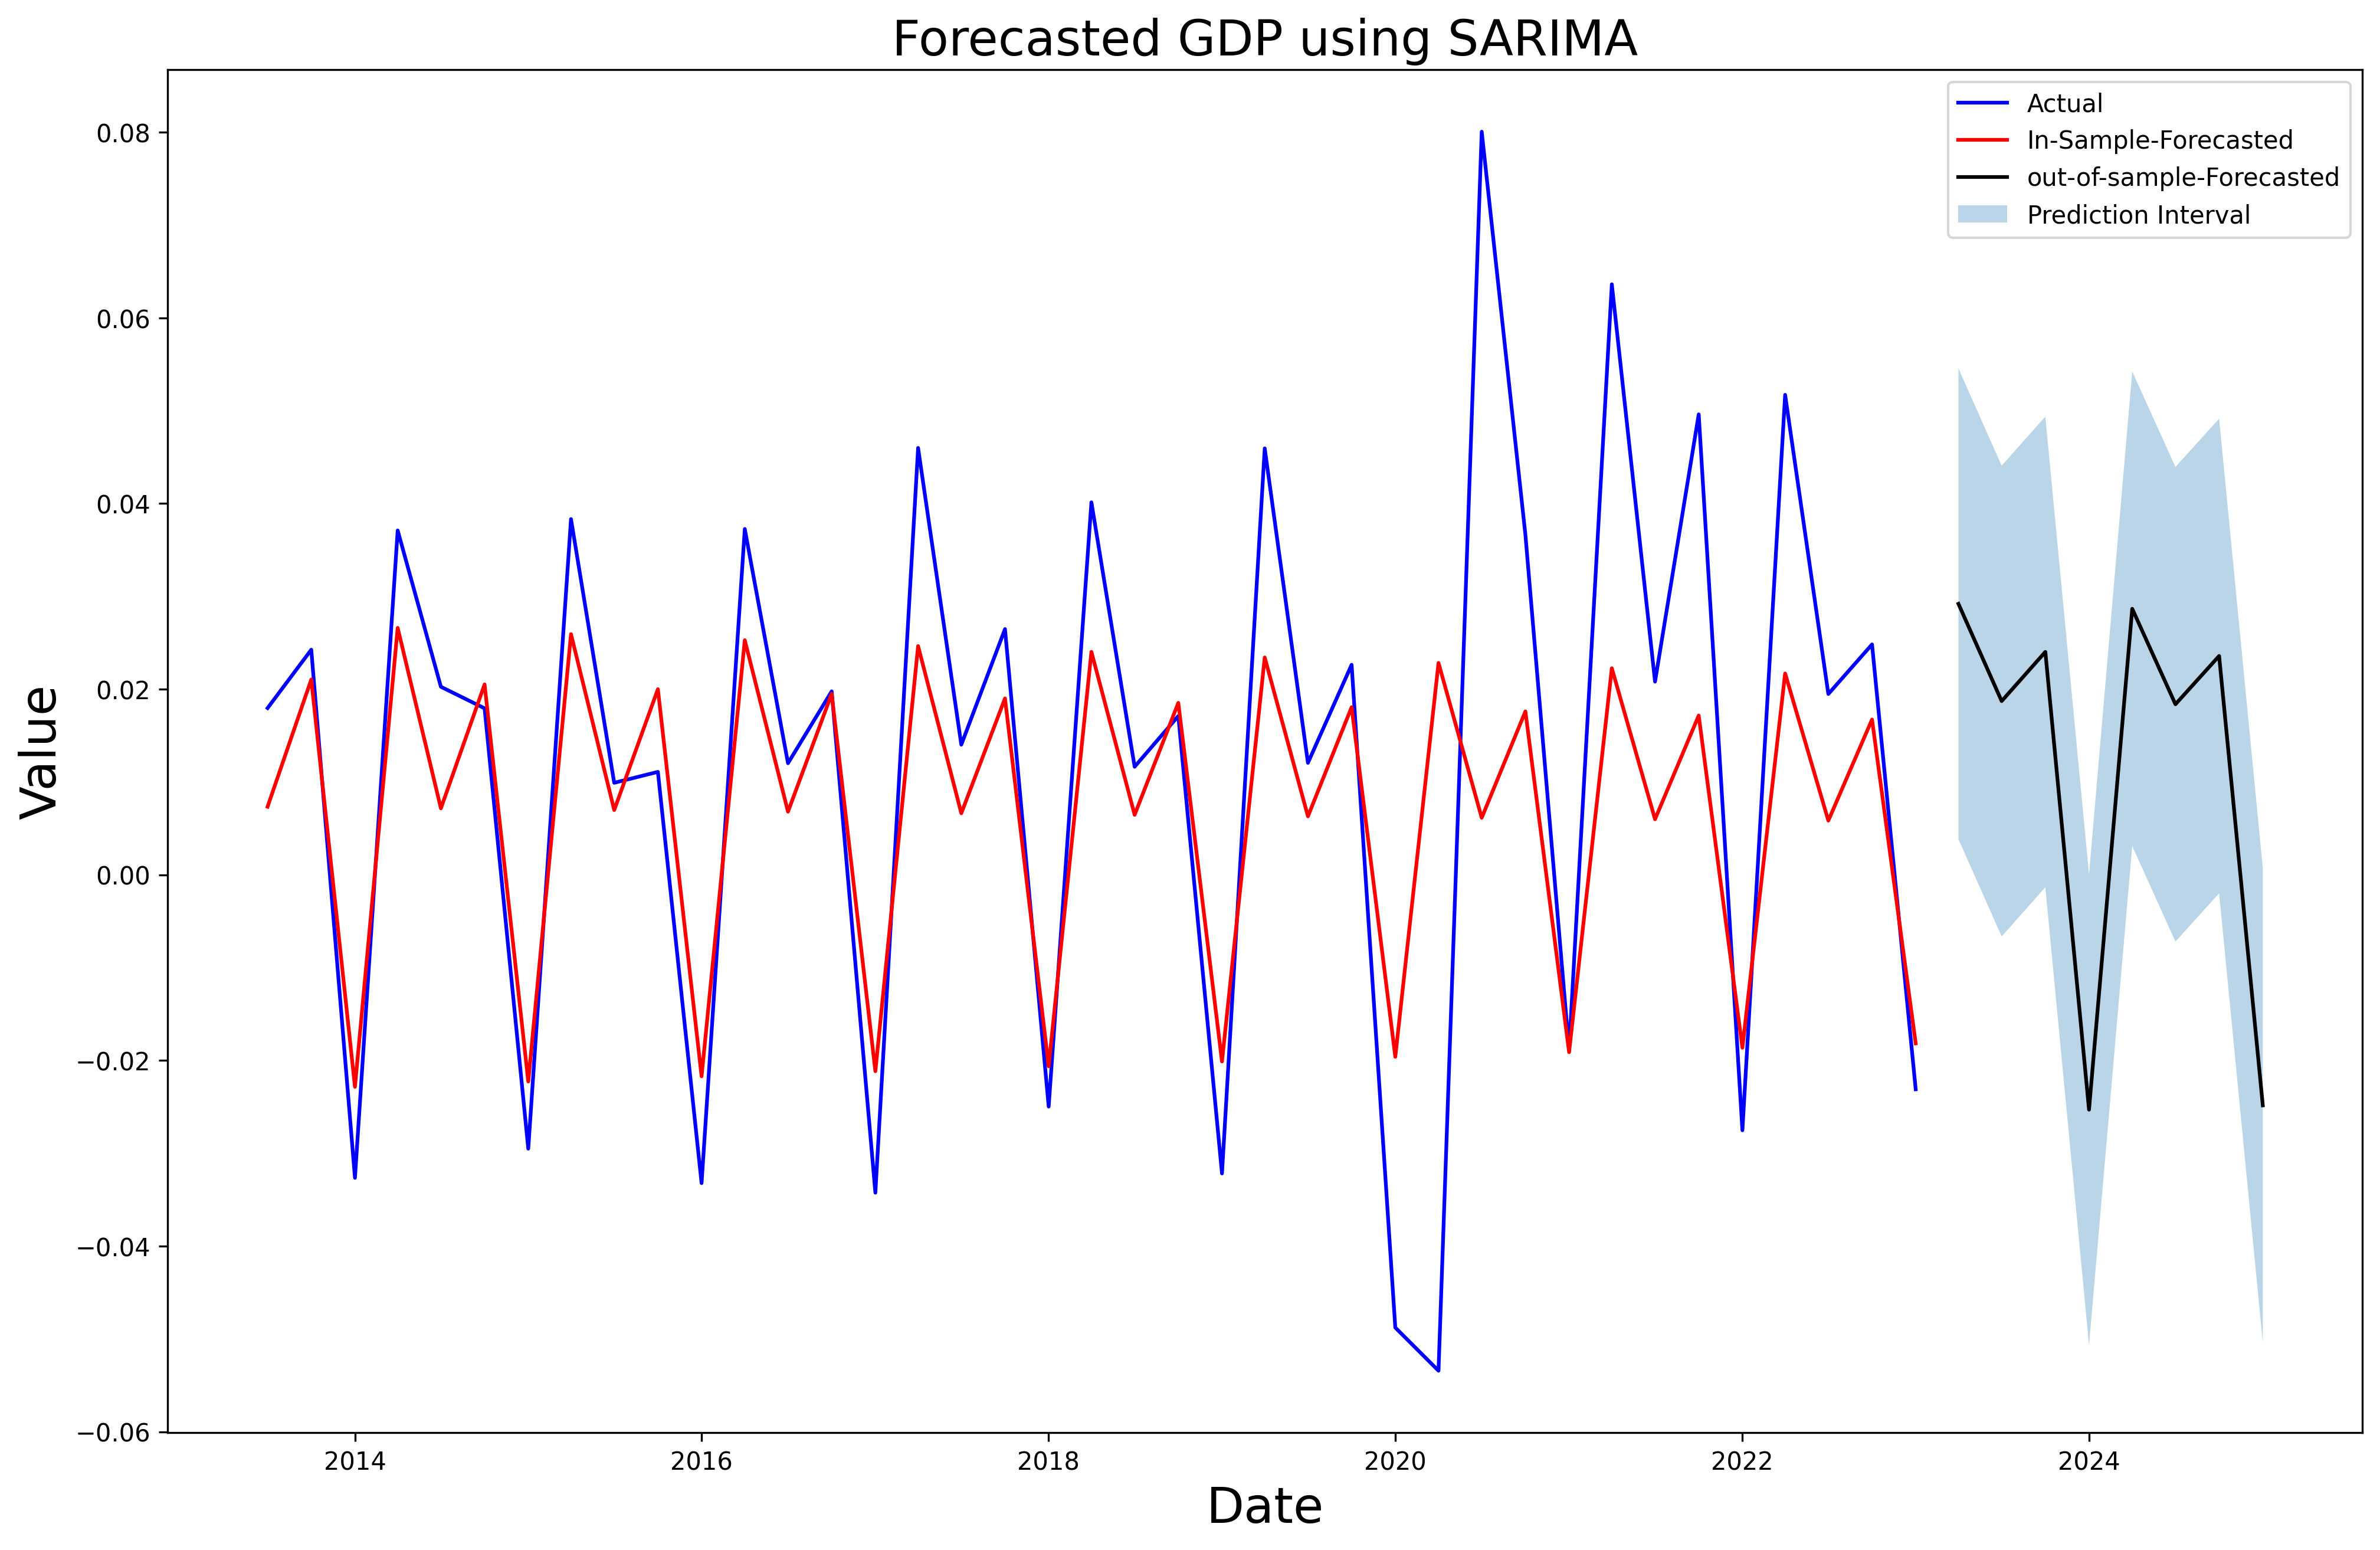

In [52]:
# Plot actual vs. predicted values
plt.figure(figsize=(16, 10),dpi=300)
plt.plot(test.index, test.values, label='Actual', color='blue')
plt.plot(test.index, final_forecast_mean, label='In-Sample-Forecasted', color='red')
plt.plot(forecast_future_mean.index, forecast_future_mean.values, label='out-of-sample-Forecasted', color='Black')
plt.fill_between(forecast_future_mean.index, forecast_future_ci.iloc[:,0], forecast_future_ci.iloc[:,1], alpha=0.3, label='Prediction Interval')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Value',fontsize=20)
plt.title('Forecasted GDP using SARIMA',fontsize=20)
plt.legend()
plt.show()

In [53]:
test.values

array([ 0.01796262,  0.02425222, -0.03265085,  0.03709963,  0.02025577,
        0.01793378, -0.02950831,  0.03832404,  0.00991137,  0.01108758,
       -0.03321782,  0.03725467,  0.0120206 ,  0.01976589, -0.03424844,
        0.04598665,  0.01401851,  0.02647541, -0.02497045,  0.0401283 ,
        0.0116411 ,  0.01710444, -0.03217679,  0.04594079,  0.01205873,
        0.02262775, -0.04878007, -0.05342945,  0.08006038,  0.03663777,
       -0.0189085 ,  0.06361865,  0.02081195,  0.04960537, -0.02752594,
        0.05170729,  0.01948048,  0.02481948, -0.02310879])

In [54]:
final_forecast_mean.values

array([ 0.00733909,  0.02104154, -0.02284608,  0.02659825,  0.00715446,
        0.02051218, -0.02227132,  0.02592909,  0.00697447,  0.01999614,
       -0.02171102,  0.02527677,  0.006799  ,  0.01949308, -0.02116481,
        0.02464086,  0.00662795,  0.01900267, -0.02063235,  0.02402095,
        0.00646121,  0.01852461, -0.02011329,  0.02341663,  0.00629866,
        0.01805857, -0.01960728,  0.02282752,  0.0061402 ,  0.01760425,
       -0.019114  ,  0.02225323,  0.00598572,  0.01716137, -0.01863313,
        0.02169338,  0.00583514,  0.01672962, -0.01816436])

> ## SARIMA-X Model

> SARIMA-X model provide a more flexible approach for our analysis, because we are also able to include independent variable covariates into the estimation. For our analysis we will try to add variables that can have some relation to the GDP such as inflation, Mortgage Rates, Unemployment, Consumer sentiment etc.

> Correlation between these variables might affect our analysis due to multi-collinearity and we won't be able to correctly identify the effect of each indivisual component. We will perform feature selection on these variables using lasso-regrssion and also check the variation-inflation-factor to eliminate the variables.

In [55]:
# Lets import the data first
Inflation = pd.read_csv('Datasets/Inflation.csv',index_col=0,parse_dates=True)
Mortgage = pd.read_csv('Datasets/Mortgage Rate.csv',index_col=0,parse_dates=True)
Unemployment = pd.read_csv('Datasets/Unemployment.csv',index_col=0,parse_dates=True)
Sentiment = pd.read_csv('Datasets/Consumer Sentiment.csv',index_col=0,parse_dates=True)

In [56]:
inflation = Inflation.diff().dropna()
mortgage = Mortgage.diff().dropna()
unemployment = Unemployment.diff().dropna()
sentiment = Sentiment.diff().dropna()

<Axes: xlabel='DATE'>

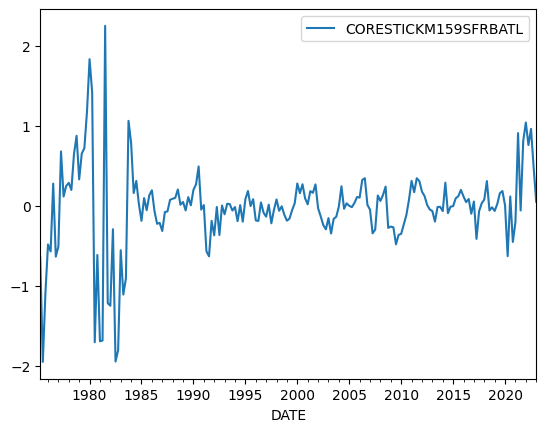

In [77]:
inflation.plot()

<Axes: xlabel='DATE'>

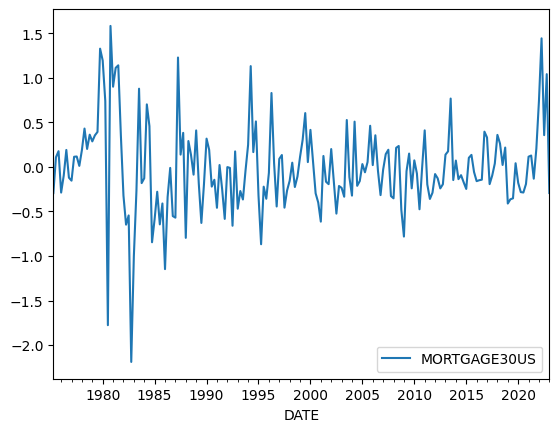

In [78]:
mortgage.plot()

In [79]:
result = kpss(inflation)

test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
critical_values = result[3]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags Used: {lags_used}')
print(f'Critical Values: {critical_values}')

Test Statistic: 0.22777545430636467
P-value: 0.1
Lags Used: 7
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\prasa\AppData\Local\Temp\ipykernel_9984\14958264.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(inflation)


In [80]:
result = kpss(mortgage)

test_statistic = result[0]
p_value = result[1]
lags_used = result[2]
critical_values = result[3]

print(f'Test Statistic: {test_statistic}')
print(f'P-value: {p_value}')
print(f'Lags Used: {lags_used}')
print(f'Critical Values: {critical_values}')

Test Statistic: 0.09656703376373306
P-value: 0.1
Lags Used: 5
Critical Values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\prasa\AppData\Local\Temp\ipykernel_9984\320600091.py:1: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(mortgage)


In [57]:
exog_df = pd.DataFrame(gdp_percent,index=gdp_percent.index)

In [58]:
dataframes = [Inflation,Mortgage,Unemployment,Sentiment]
for df in dataframes:
    exog_df = exog_df.merge(df,how='left',left_index=True,right_index=True)

In [59]:
exog_df.rename({'CORESTICKM159SFRBATL':'Inflation',
           'MORTGAGE30US':'Mortgage',
           'NROU':'Unemployment',
           'UMCSENT':'Sentiment'},axis=1,inplace=True)

> ### Variance Inflation Factor

In [60]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [61]:
# 'X' is DataFrame of independent variables
X = exog_df[['Inflation','Mortgage', 'Unemployment', 'Sentiment']]

In [62]:
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [63]:
vif_data

feature         VIF
0     Inflation   10.908023
1      Mortgage   17.392311
2  Unemployment  118.732605
3     Sentiment   66.161851

> Generally we reject the variable with high VIF value. In this case we might reject Unemployment and sentiment data. Lets also perform Lasso Regression and check the results

> Lets make our data stationary by taking differencing

In [64]:
gdp_percent_df = pd.DataFrame(gdp_percent,index=gdp_percent.index)

In [65]:
dataframes = [inflation,mortgage,unemployment,sentiment]
for df in dataframes:
    gdp_percent_df = gdp_percent_df.merge(df,how='left',left_index=True,right_index=True)

In [66]:
gdp_percent_df.rename({'CORESTICKM159SFRBATL':'Inflation',
           'MORTGAGE30US':'Mortgage',
           'NROU':'Unemployment',
           'UMCSENT':'Sentiment'},axis=1,inplace=True)

In [67]:
gdp_percent_df = gdp_percent_df.dropna()
gdp_percent_df

GDP  Inflation  Mortgage  Unemployment  Sentiment
DATE                                                              
1975-07-01  0.021895  -1.951722  0.108462      0.008725   2.900000
1975-10-01  0.076344  -1.091698  0.176923      0.008098  -0.100000
1976-01-01 -0.031742  -0.483338 -0.287692      0.007477   9.000000
1976-04-01  0.054774  -0.571591 -0.096154      0.006849  -1.300000
1976-07-01  0.002562   0.276992  0.190769      0.006205   6.400000
...              ...        ...       ...           ...        ...
2022-01-01 -0.027526   1.040023  0.743077     -0.005514  -6.766667
2022-04-01  0.051707   0.758523  1.443846     -0.004923  -5.266667
2022-07-01  0.019480   0.960036  0.356923     -0.004430  -1.766667
2022-10-01  0.024819   0.481127  1.041538     -0.004024   2.700000
2023-01-01 -0.023109   0.048914 -0.292308     -0.003696   5.833333

[191 rows x 5 columns]

> Lets find the optimal order for the model

In [68]:
# Hyperparameter Tuning; Grid Search for ARIMA

def assess_SARIMA_model(data, exog, order, seasonal_order):
    
    model = SARIMAX(data,
                    exog=exog,
                    order=order, 
                    seasonal_order=seasonal_order, 
                    enforce_stationarity=False)
    
    results = model.fit()
    
#     forecast_steps = len(test)
#     forecast = results.get_forecast(steps=forecast_steps)
#     forecast_mean = forecast.predicted_mean
    
#     error = mean_squared_error(test,
#                                forecast_mean)
    
    aicc = results.aicc
    
    return aicc #, error

def assess_models(data, exog, p_values, d_values, q_values, P_values, D_values, Q_values, s):
    
    best_score, best_cfg = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                for P in P_values:
                    for D in D_values:
                        for Q in Q_values:
                            order = (p, d, q)
                            seasonal_order = (P,D,Q,s)
                            try:
                                aicc  = assess_SARIMA_model(data, exog, order, seasonal_order)
                                if aicc < best_score:
                                    best_score, best_cfg = aicc, [order, seasonal_order]

#                                 print("SARIMA%s MSE = %.7f" % ([order, seasonal_order], mse))

                            except:
                                continue
    print("Best ARIMA%s AICc = %.7f" % (best_cfg, best_score))

In [69]:
# parameters to use for assessment

p_values = [0, 1, 2]
d_values = range(0, 2)
q_values = range(0, 2)
P_values = [0, 1, 2]
D_values = range(0, 2)
Q_values = range(0, 2)
s = 4 # seasonal component
data = gdp_percent_df['GDP']
exog = gdp_percent_df[['Inflation','Mortgage']]

In [70]:
assess_models(data, exog, p_values, d_values, q_values, P_values, D_values, Q_values, s)

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No freque

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.p

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Lik

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWar

Best ARIMA[(0, 0, 0), (1, 0, 1, 4)] AICc = -1084.1863941


C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [71]:
#Lets predict out of sample data by spliting the data

train_size = int(0.8 * len(gdp_percent_df))  
train, test = gdp_percent_df[:train_size], \
                gdp_percent_df[train_size:]

In [72]:
model = SARIMAX(train['GDP'],
               exog=train[['Inflation','Mortgage']],
               order=(0,0,0),
               seasonal_order=(1,0,1,4))

results = model.fit()

forecast = results.get_forecast(steps=len(test),exog=test[['Inflation','Mortgage']])

forecast_mean = forecast.predicted_mean

forecast_ci = forecast.conf_int()

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [73]:
evaluateModel(test['GDP'],forecast_mean,results)

MAE:0.01266874433267579
MSE:0.0004367078162509294
RMSE:0.02089755526971826
AICc:-958.2191269106808


> We can see that there is improvement in the RMSE and AICc score from the earlier normal SARIMA model.

>P.S. Its not neccessary to get better results from SARIMAX where we use more predictor variables

In [74]:
sarimax_model = \
    SARIMAX(gdp_percent_df['GDP'],
           exog = gdp_percent_df[['Inflation','Mortgage']],
           order = (0, 0, 0),
           seasonal_order = (1, 0, 1, 4),
           enforce_stationarity=False)

sarimax_results = sarimax_model.fit()

C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)
C:\Users\prasa\anaconda3\envs\myenv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  self._init_dates(dates, freq)


In [75]:
# Perform the Ljung-Box and Box-Pierce test
lags = 10

acorr_ljungbox(sarimax_results.resid, lags=lags, return_df=True, boxpierce=True).iloc[-1]

lb_stat      7.120474
lb_pvalue    0.714025
bp_stat      6.876424
bp_pvalue    0.737058
Name: 10, dtype: float64

> Hence we can confirm that no correlation in the residuals

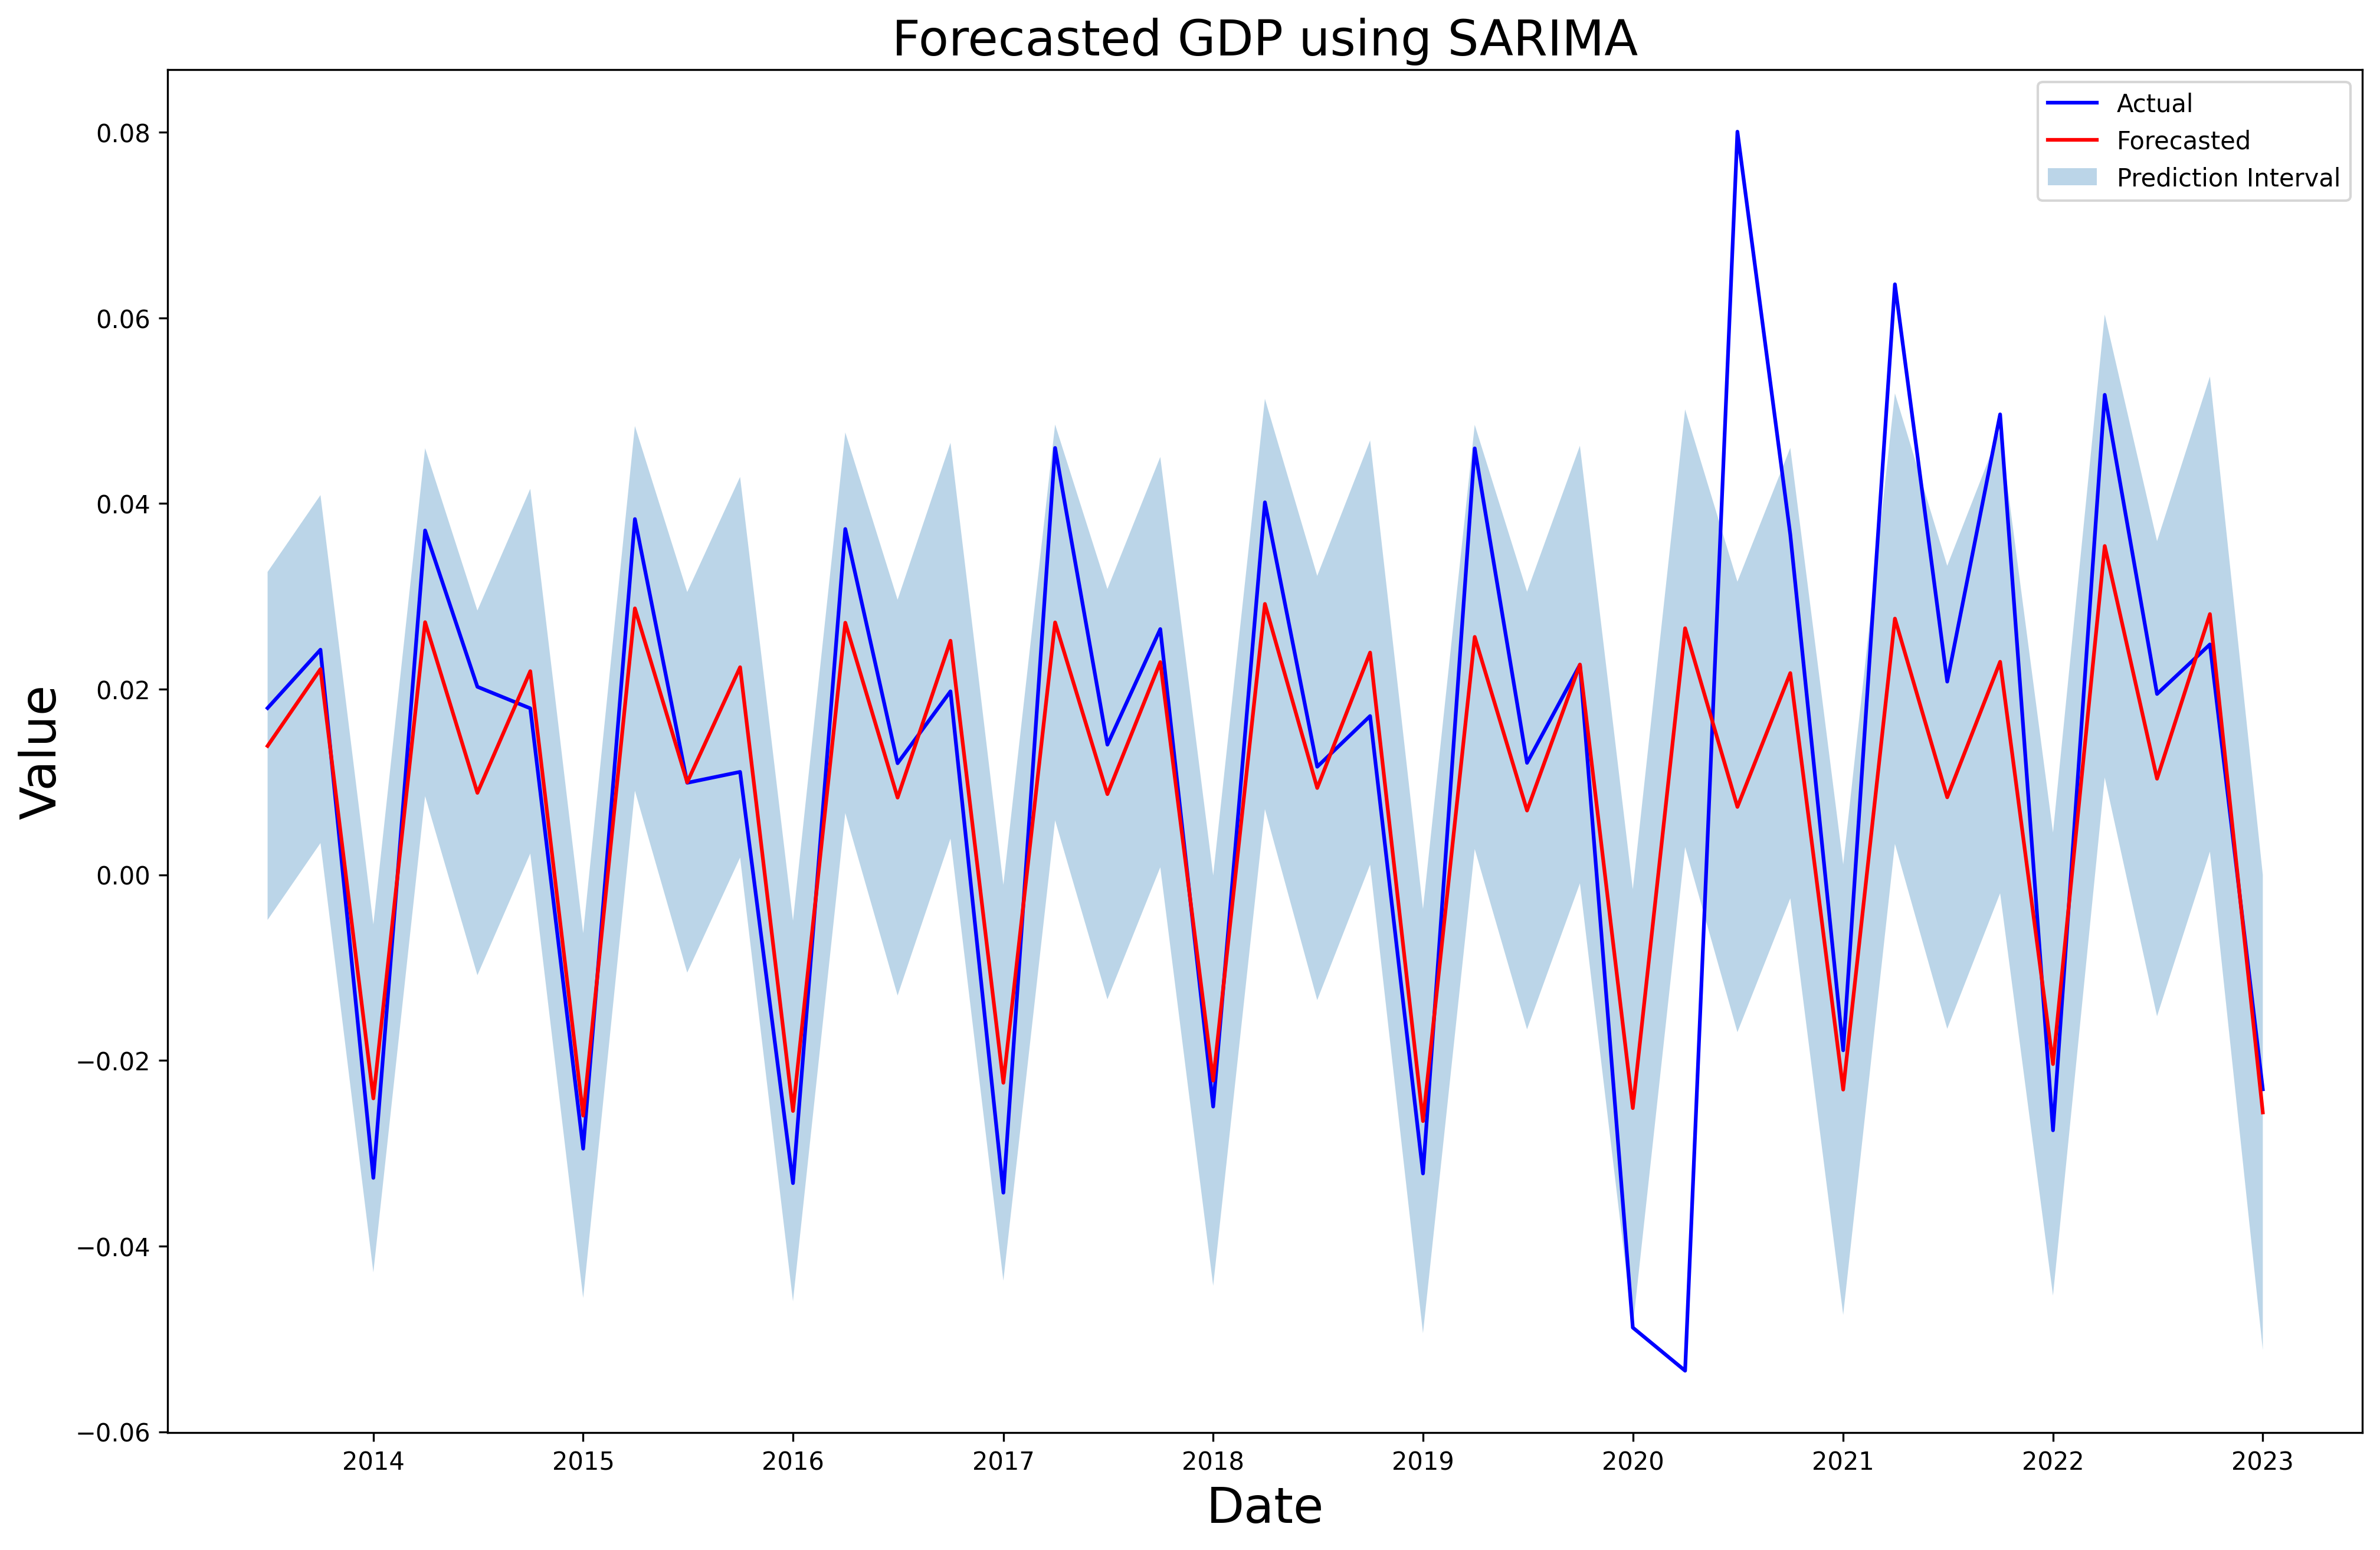

In [76]:
# Plot actual vs. predicted values
plt.figure(figsize=(16, 10),dpi=300)
plt.plot(test.index, test['GDP'].values, label='Actual', color='blue')
plt.plot(test.index, forecast_mean, label='Forecasted', color='red')
plt.fill_between(test.index, forecast_ci.iloc[:,0], forecast_ci.iloc[:,1], alpha=0.3, label='Prediction Interval')
plt.xlabel('Date',fontsize=20)
plt.ylabel('Value',fontsize=20)
plt.title('Forecasted GDP using SARIMA',fontsize=20)
plt.legend()
plt.show()